In [12]:
"""
Dynamic Li-Sr isotope box model

@author: Xi-Kai Wang, Datu Adiatma, Xiao-Ming Liu

"""

'\nDynamic Li-Sr isotope box model\n\n'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
plt.rc('font', family = 'arial')

In [14]:
# -----------------------------------------------------
# Function for LOWESS smoothing curve and 95% confidence interval

def lowess_with_confidence_bounds(
    x, y, eval_x, N, conf_interval=0.95, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


In [15]:
#Read Sr data
df_sr = pd.read_csv("Dera_2011.csv")[["Age", "Sr"]]
arr = df_sr.to_numpy()
real_Sr_age = arr[:, 0];
real_Sr = arr[:, 1];


#read Li data
df = pd.read_csv("Li_after_screening.csv")
arr = df.to_numpy()
real_age = arr[:, 2]
real_d7Li = arr[:, 1]



In [16]:
#Strontium mass balance model, use mass balance model to calculate strontium ratio of seawater


def simNSr(jr, jh,jdia,jcarb):
    """
    Strontium Mass Balance

    Parameters
    ----------
    jr :    riverine flux
    
    jh :    MOR hydrothermal flux
    
    jdia :  diagenetic flux
    
    jcarb : Sr uptake during carbonate deposition
    
    Returns
    -------
    nsr : Seawater Sr reservoir size in mol
    
    """
    nsr = jr + jh + jdia - jcarb
    return nsr


def simRSr(n, rsw, jr, rr, jh, rh, jdia,rdia):
    """
    Parameters
    jr: Sr riverine flux （Gmol/y）
    
    rr: Sr isotope ratio of riverine flux
    
    jh: Sr MOR hydrothermal flux （Gmol/y）

    rh: Sr isotope ratio of MOR hydrothermal flux 

    jdia: Sr diagenetic flux （Gmol/y）

    rdia: Sr isotope ratio of diagenetic flux
    
    rsw: Sr isotope ratio of seawater
    
    n: Sr reservoir of the ocean （Gmol）
    
    
    
    returns : strontium ratio of seawater
    """
    
    rSr = ((jr * (rr - rsw) + jh * (rh - rsw)) + jdia *(rdia - rsw))/ n
    return rSr;

def run_Sim(nt, dt, age, rsw, n, jr, rr, jh, rh, jdia, rdia):
    
    #Initial seawater value (steady state)
    rsw[0] = (jr[0]*rr[0] + jh[0]*rh[0] +jdia[0]*rdia[0])/(jr[0]+jh[0]+jdia[0])

    jcarb0 = jr[0] + jh[0] +jdia[0]
    k = jcarb0 / n[0]
    jcarb = jcarb0
    
    for i in range(nt-1):
        n[i+1] = n[i] + simNSr(jr[i], jh[i], jdia[i],jcarb)*dt
        rsw[i+1] = rsw[i] + simRSr(n[i], rsw[i], jr[i], rr[i], jh[i], rh[i],jdia[i], rdia[i])*dt
        jcarb = k * n[i]
        
    return rsw;

In [32]:
#Lithium mass balance model
def simNLi(Fr, Fh, Fsed, Falt):
    """
    Lithium Mass Balance

    Parameters
    ----------
    Fr : Li riverine flux
         
    Fh : Li MOR hydrothermal flux
        
    Fsed : Li reverse weathering
       
    Fl: li low-T alteration
    
    Returns
    -------
    nLi : Seawater Li reservoir size in mol
    
    """
    nLi = Fr + Fh - Fsed - Falt
    return nLi

def simRLi(Dsw, N, Fr, Rr, Fh, Rh, Fsed, Dsed, Falt, Dalt):
    """
    
    Parameters
    ----------
    N ：total amount of Li in seawater (mol)
    
    Dsw: seawater d7Li
    
    BOX MODEL INPUT FLUXES:
    
    Fr: riverine Li flux in Gmol/y
    Dr: riverine d7Li
    
    Fh: high-T hydrothermal Li flux in Gmol/y
    Dh: high-T hydrothermal d7Li
   
    BOX MODEL OUTPUT FLUXES:
    
    Falt: low-T hydrothermal Li flux in Gmol/y
    Dalt: fractionation factor between Falt and seawater

    Fsed : maac Li flux in Gmol/y
    Dsed : fractionation factor between maac and seawater

    """
    d7Li = ((Fr * (Rr - Dsw)) + Fh * (Rh - Dsw) + Fsed * Dsed + Falt * Dalt)/N
    
    return d7Li


def run_Li (N, nt, dt,rsw, fr, rr, fh, rh, fsed, dsed, falt, dalt):
    """
    solving diff. equations using forward Euler method

    Parameters:
    
    nt : numbers of time steps
    dt: the size of each time step
    age: age in million years

    BOX MODEL INPUT FLUXES:
    Fr: riverine Li flux in Gmol/y
    Dr: riverine d7Li
    
    Fh: MOR hydrothermal Li flux in Gmol/y
    Dh: MOR hydrothermal d7Li
   
    BOX MODEL OUTPUT FLUXES:
    Falt: low-T hydrothermal Li flux in Gmol/y
    Dalt: fractionation factor between Falt and seawater

    Fsed : maac Li flux in Gmol/y
    Dsed : fractionation factor between maac and seawater

    Returns:
    Dsw: lithium isotope ratio of seawter

    """

    #steady state initial seawater value @ 180 Ma:
    rsw0 = (fr[0]* rr[0] + rh[0]* fh[0] + dsed[0] * fsed[0] + falt[0]* dalt[0]) / (fr[0] + fh[0])
    rsw[0] = rsw0
    
    kalt = falt[0]/N[0]
    ksed = fsed[0]/N[0]
    
    for i in range(nt-1):
        N[i+1] = N[i] + simNLi(fr[i], fh[i], fsed[i],falt[i])
        rsw[i+1]= rsw[i] + (simRLi(rsw[i], N[i], fr[i], rr[i], fh[i], rh[i], fsed[i], dsed[i], falt[i], dalt[i]) * dt)
        falt[i + 1] = kalt * N[i + 1]
        fsed[i + 1] = ksed * N[i + 1]
        
    return rsw

In [33]:
# Define array of time
# --------------------
tmin = 180      # start of Middle Jurassic
tmax = 145      # end of late Jurassic 
nt = 100000     # modelling steps
dt = (tmin - tmax)*1e6 / nt
time = np.linspace(0, (tmin-tmax)*1e6, nt)
age = np.linspace(tmin, tmax, nt)

In [59]:
# Steady state
# Initial Sr isotope values and paramaters 
# -----------------------------

# High-T hydrothermal flux   
Sr_Jh0 = 1.5e10 *1.14  # Jones and Jenkyns (2001) * oceanic spreading rate by Berner (1994)
Sr_Jh = np.ones(nt)*Sr_Jh0

# Hydrothermal isotopic ratio
Sr_Rh0 = 0.7033        # Jones and Jenkyns (2001)
Sr_Rh = np.ones(nt) * Sr_Rh0


# diagenetic flux   
Sr_Jdia0 = 3.4e9       # Palmer and Edmond (1989)
Sr_Jdia= np.ones(nt) * Sr_Jdia0 

# diagenetic flux   isotopic ratio
Sr_Rdia0 = 0.7084      # Palmer and Edmond （1989）
Sr_Rdia = np.ones(nt) * Sr_Rdia0 

# Riverine isotopic ratio
Sr_Rriv0 = 0.7100      # Ingram et al (1994)
Sr_Rriv = np.ones(nt) * Sr_Rriv0

# Riverine flux
# Calculate Sr riverine flux to meet the steady state mass balance
Sr_Jriv0 = (Sr_Jh0 * (Sr_Rh0 - 0.70729) + Sr_Jdia0 * (Sr_Rdia0 - 0.70729))/(0.70729-Sr_Rriv0)
Sr_Jriv = np.ones(nt) * Sr_Jriv0


# Array to store isotopic ratio of seawater and rate of change
Sr_Rsw = np.zeros(nt)

# Reservoir size
Sr_N = np.ones(nt) * 1.25e17   #Jones and Jenkyns (2001)


In [60]:
#Initial Li isotopes values and parameters from monte carlo results

#Build array to store all seawater d7Li
Li_rsw = np.ones(nt) 

#N total amount of Li in seawater
Li_N = np.ones(nt) * 3.4e16


#Riverine flux Gmol/year
Li_fr0 = 19107987130.31829
Li_fr = np.ones(nt) * Li_fr0

#Riverine isotope ratio
Li_rr0 = 16.064514764173396
Li_rr = np.ones(nt) * Li_rr0

#MOR Hydrothermal Gmol/y
Li_fh0 = 14765731304.111275
Li_fh = np.ones(nt) * Li_fh0 

#MOR Hydrothermal d7Li
Li_rh0 = 8.3             
Li_rh = np.ones(nt) * Li_rh0   

#Low-T hydrothermal Gmol/y
Li_falt0 = 17673244400.571945
Li_falt = np.ones(nt) * Li_falt0

#Low-T fractionation factor
Li_dalt0 = 10.969718070350824
Li_dalt = np.ones(nt) * Li_dalt0

#reverse weathering flux Gmol/y
Li_fsed0 = 16200474033.857616
Li_fsed = np.ones(nt) * Li_fsed0

#reverse weathering fractionation factor
Li_dsed0 = 15.61059573896001
Li_dsed = np.ones(nt) * Li_dsed0


In [46]:
# Run the model steady-state
Li_Fsw_0 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)

Sr_Rsw_0 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)


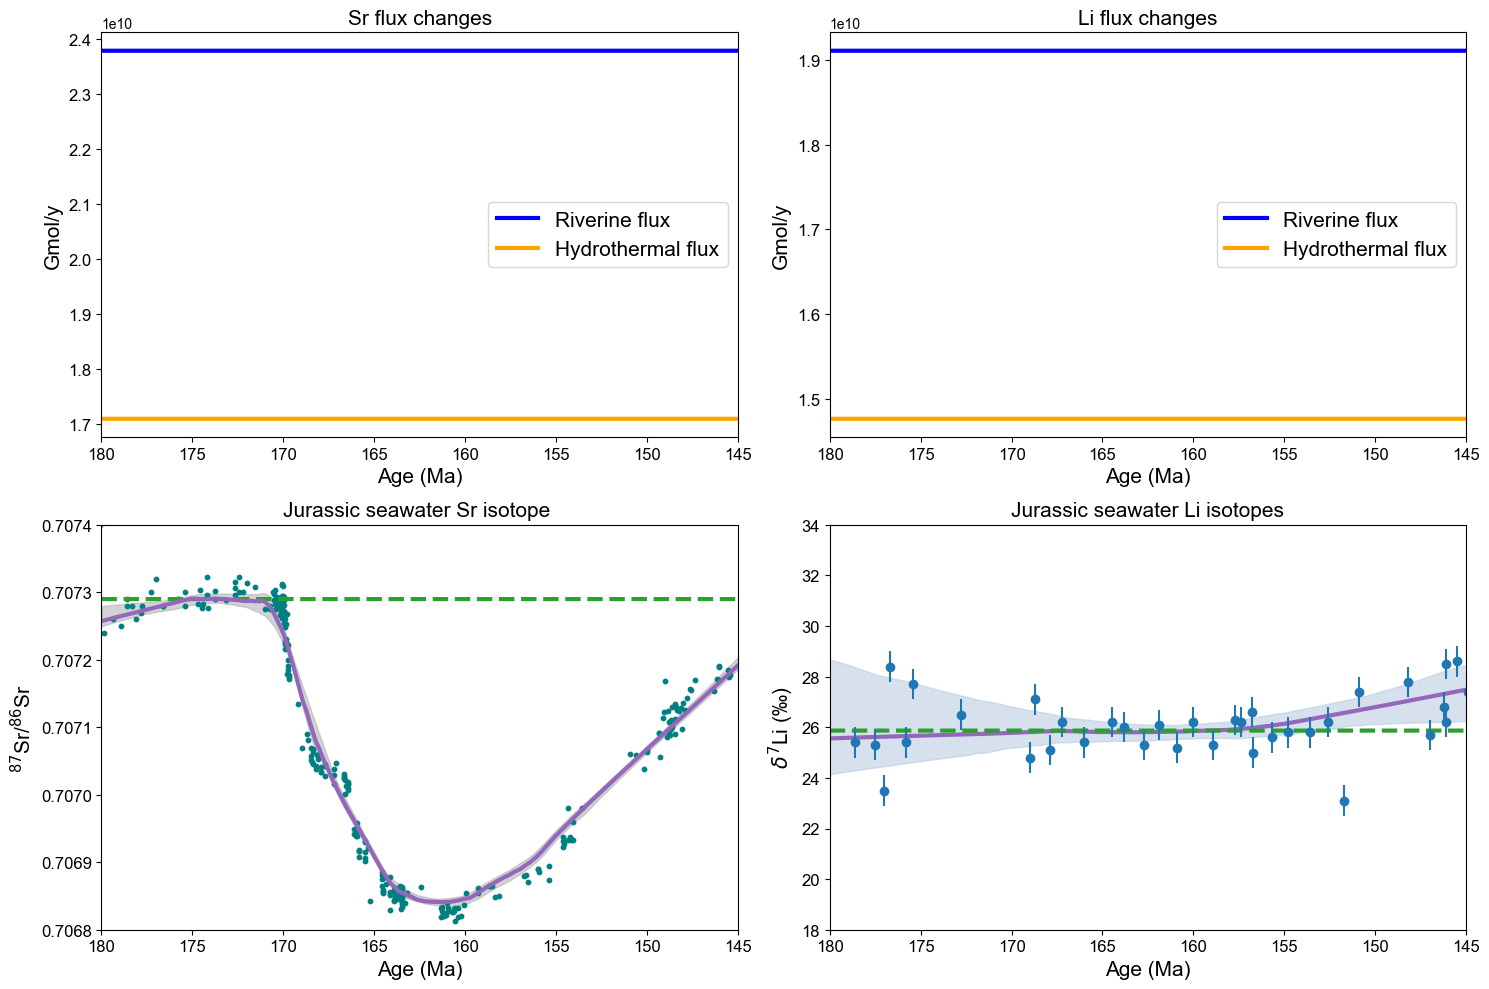

In [37]:

#-----------------------------------------------------------------------------------------------------------------
#plot the data
fig, ax = plt.subplots(2, 2, figsize = (15, 10))


#plot Sr fluxes change
ax[0, 0].plot(age, Sr_Jriv, color = "blue", label = "Riverine flux", lw = 3)  
ax[0, 0].plot(age, Sr_Jh, color = "orange", label = "Hydrothermal flux", lw = 3) 
ax[0, 0].set_title("Sr flux changes", fontsize = 15)
ax[0, 0].set_xlim(145, 180)
ax[0, 0].tick_params(axis='x', labelsize = 12)
ax[0, 0].tick_params(axis='y', labelsize = 12)
ax[0, 0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0, 0].set_ylabel('Gmol/y', fontsize = 15)
ax[0, 0].tick_params(axis='x', labelsize = 12)
ax[0, 0].tick_params(axis='y', labelsize = 12)
ax[0, 0].invert_xaxis() 
ax[0, 0].legend(loc = "center right", fontsize = 15)



#plot Li fluxes change
ax[0, 1].plot(age, Li_fr, color = "blue", label = "Riverine flux", lw = 3)  
ax[0, 1].plot(age, Li_fh, color = "orange", label = "Hydrothermal flux", lw = 3) 
ax[0, 1].set_title("Li flux changes", fontsize = 15)
ax[0, 1].set_xlim(145, 180)
ax[0, 1].tick_params(axis='x', labelsize = 12)
ax[0, 1].tick_params(axis='y', labelsize = 12)
ax[0, 1].set_xlabel('Age (Ma)', fontsize = 15)
ax[0, 1].tick_params(axis='x', labelsize = 12)
ax[0, 1].tick_params(axis='y', labelsize = 12)
ax[0, 1].set_ylabel('Gmol/y', fontsize = 15)
ax[0, 1].legend(loc = "center right", fontsize = 15)
ax[0, 1].invert_xaxis() 


#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[1, 0].fill_between(eval_x, bottom, top, alpha=0.5, color="darkgrey")

#plot Sr original data
ax[1, 0].plot(age, Sr_Rsw_0, lw = 3, color = "C2", ls = '--')
ax[1, 0].set_title("Jurassic seawater Sr isotope ", fontsize = 15)
ax[1, 0].set_ylim(0.7068, 0.7074)
ax[1, 0].scatter(real_Sr_age, real_Sr, color = "teal", s = 10);
ax[1, 0].set_xlim(145, 180)
ax[1, 0].invert_xaxis()
ax[1, 0].plot(eval_x, smoothed, c = "C4", linewidth = 3)
ax[1, 0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[1, 0].set_xlabel('Age (Ma)', fontsize = 15)

ax[1, 0].tick_params(axis='x', labelsize = 12)
ax[1, 0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1, 1].plot(eval_x, smoothed, c = "C4", linewidth = 3)
ax[1, 1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#---------------------------------------------------------

ax[1, 1].plot(age, Li_Fsw_0, lw = 3, color = "C2", ls = '--')
ax[1, 1].set_ylim(20, 32)
ax[1, 1].set_xlim(145, 180)
ax[1, 1].invert_xaxis()
ax[1, 1].set_title("Jurassic seawater Li isotopes", fontsize = 15)
ax[1, 1].set_ylim(18, 34)
ax[1, 1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1, 1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1, 1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1, 1].tick_params(axis='x', labelsize = 12)
ax[1, 1].tick_params(axis='y', labelsize = 12)

plt.tight_layout()
plt.show()
# save figure
# fig.savefig('Sceario_steady_state.eps', format='eps')

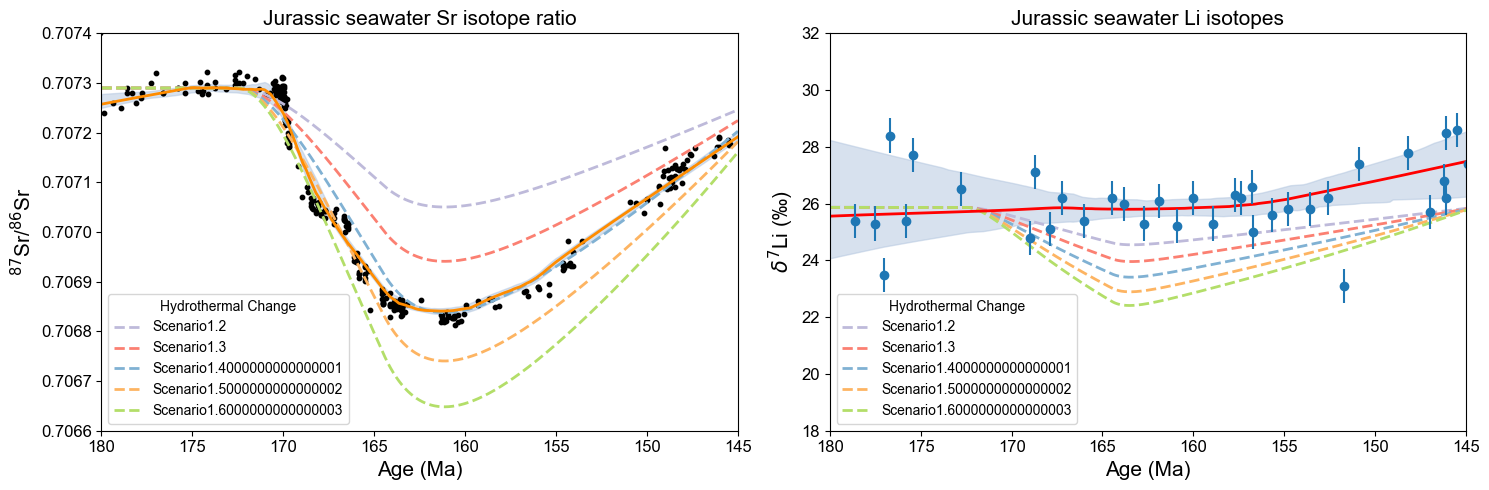

In [39]:
# SCENARIO 1.1 MOR FLUX CHANGE ONLY

#set turnning point time
start_age = 172
stop_age = 164

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

#----------------------------------------------------------------------------

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Introduce changes
p = 1.2
for i in range(5):
    Sr_Jh[start:stop] = np.linspace(Sr_Jh[0], Sr_Jh[0]*p, (stop-start))
    Sr_Jh[stop:] = np.linspace(Sr_Jh[0]*p, Sr_Jh0, (len(Sr_Jriv) - (stop)))
    
    Li_fh[start:stop] = np.linspace(Li_fh[0], Li_fh[0]*p, (stop-start))
    Li_fh[stop:] = np.linspace(Li_fh[0]*p, Li_fh[0], (len(Li_fr) - (stop)))

    #Run the model
    Li_Fsw_1_1 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
    Sr_Rsw_1_1 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)

    label = f"Scenario{p}"
    
    ax[0].plot(age, Sr_Rsw_1_1, lw = 2, color = plt.cm.Set3(i+2), ls = '--', label = label)
    ax[1].plot(age, Li_Fsw_1_1, lw = 2, color = plt.cm.Set3(i+2), ls = '--', label = label)

    p += 0.1
    
#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Sr original data
ax[0].set_title("Jurassic seawater Sr isotope ratio", fontsize = 15)
ax[0].set_ylim(0.7066, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 2)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)



#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 2)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")



#plot Li original data
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotopes", fontsize = 15)
ax[1].set_ylim(18, 32)
ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)

#---------------------------------------------------------
#add lengends
ax[0].legend(title="Hydrothermal Change", fontsize=10, loc="best")
ax[1].legend(title="Hydrothermal Change", fontsize=10, loc="best")

plt.tight_layout()
plt.show()
# # save figure
# fig.savefig('Scenario_1.pdf', format='pdf')

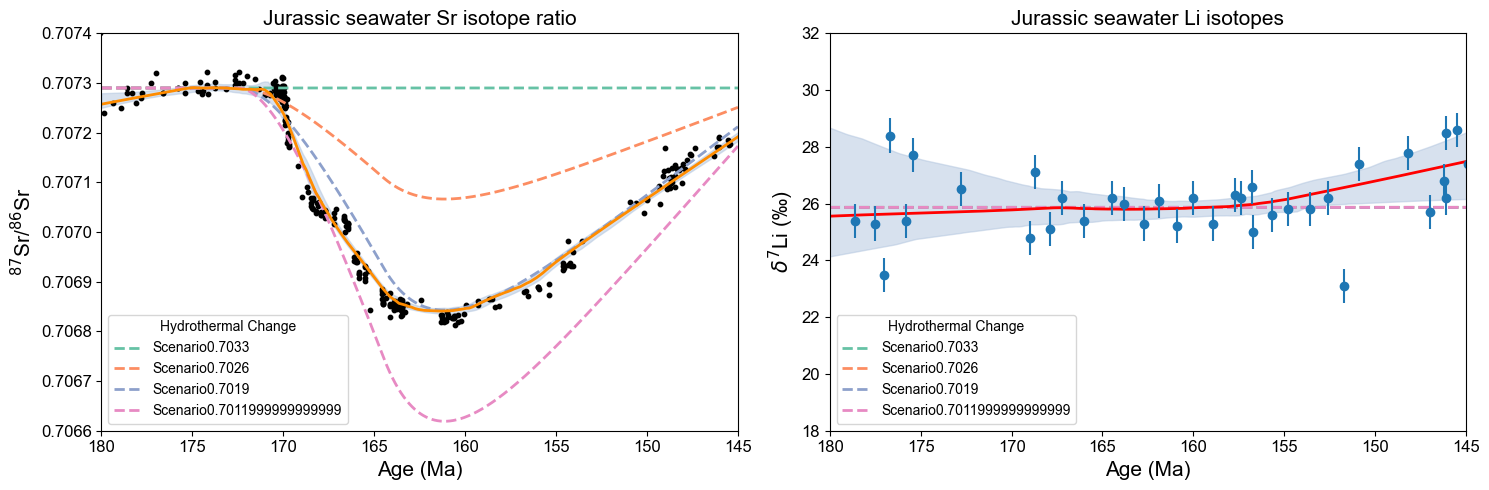

In [43]:
# SCENARIO 1.2 MOR ISOTOPE RATIO CHANGE ONLY

#set turnning point time
start_age = 172
stop_age = 164

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

#----------------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Introduce changes
p = 0.7033
for i in range(4):
    Sr_Rh[start:stop] = np.linspace(Sr_Rh[0], p, (stop-start))
    Sr_Rh[stop:] = np.linspace(p, Sr_Rh[0], (len(Sr_Rh) - (stop)))

    #Run the model
    Li_Fsw_1_2 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
    Sr_Rsw_1_2 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)

    label = f"Scenario{p}"
    
    ax[0].plot(age, Sr_Rsw_1_2, lw = 2, color = plt.cm.Set2(i), ls = '--', label = label)
    ax[1].plot(age, Li_Fsw_1_2, lw = 2, color = plt.cm.Set2(i), ls = '--', label = label)

    p -= 0.0007

    
#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Strontium original data
ax[0].set_title("Jurassic seawater Sr isotope ratio", fontsize = 15)
ax[0].set_ylim(0.7066, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 2)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 2)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Li original data
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotopes", fontsize = 15)
ax[1].set_ylim(18, 32)
ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)

#---------------------------------------------------------
#add lengends
ax[0].legend(title="Hydrothermal Change", fontsize=10, loc="best")
ax[1].legend(title="Hydrothermal Change", fontsize=10, loc="best")

plt.tight_layout()
plt.show()
# # save figure
# fig.savefig('Scenario_1_2.pdf', format='pdf')




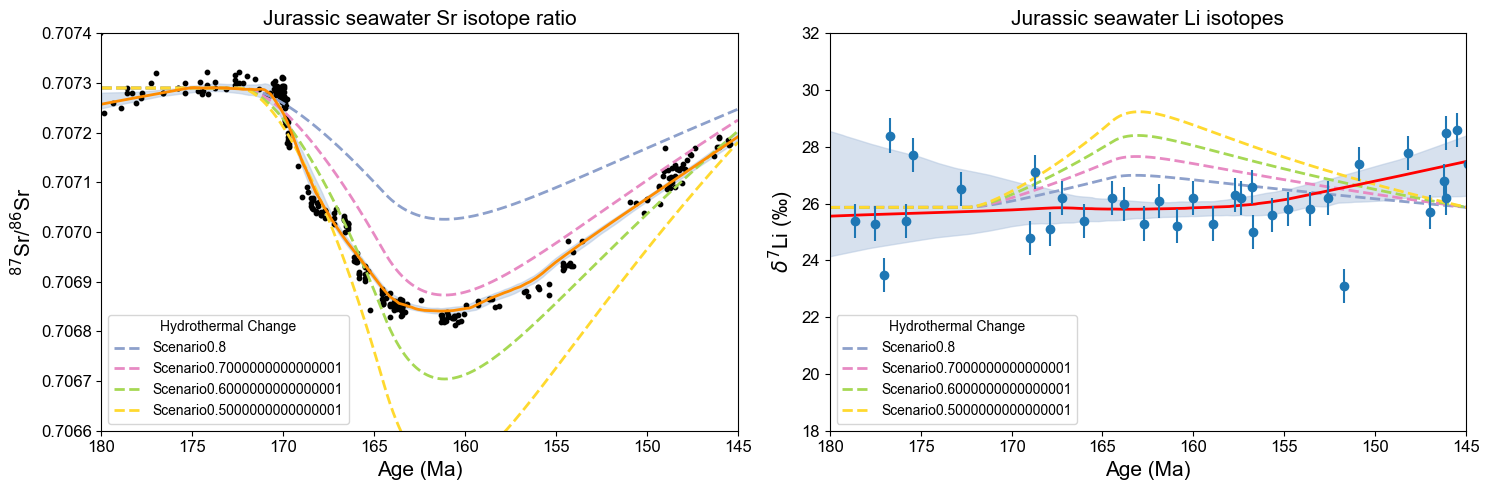

In [49]:
# SCENARIO 2.1 RIVERINE FLUX CHANGE ONLY

#set turnning point time
start_age = 172
stop_age = 164

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

#----------------------------------------------------------------------------
#plot the data
fig, ax = plt.subplots(1, 2, figsize = (15, 5))


# Introduce changes
p = 0.8
for i in range(4):
    Sr_Jriv[start:stop] = np.linspace(Sr_Jriv[0], Sr_Jriv[0]*p, (stop-start))
    Sr_Jriv[stop:] = np.linspace(Sr_Jriv[0]*p, Sr_Jriv[0], (len(Sr_Jriv) - (stop)))
    
    Li_fr[start:stop] = np.linspace(Li_fr[0], Li_fr[0]*p, (stop-start))
    Li_fr[stop:] = np.linspace(Li_fr[0]*p, Li_fr[0], (len(Li_fr) - (stop)))


    #Run the model
    Li_Fsw_2_1 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
    Sr_Rsw_2_1 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)

    label = f"Scenario{p}"
    
    ax[0].plot(age, Sr_Rsw_2_1, lw = 2, color = plt.cm.Set2(i+2), ls = '--', label = label)
    ax[1].plot(age, Li_Fsw_2_1, lw = 2, color = plt.cm.Set2(i+2), ls = '--', label = label)

    p -= 0.1


#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Strontium original data
ax[0].set_title("Jurassic seawater Sr isotope ratio", fontsize = 15)
ax[0].set_ylim(0.7066, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 2)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 2)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Li original data
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotopes", fontsize = 15)
ax[1].set_ylim(18, 32)
ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)

#---------------------------------------------------------
#add lengends
ax[0].legend(title="Hydrothermal Change", fontsize=10, loc="best")
ax[1].legend(title="Hydrothermal Change", fontsize=10, loc="best")

plt.tight_layout()
plt.show()
# save figure
# fig.savefig('Scenario_2_1.pdf', format='pdf')

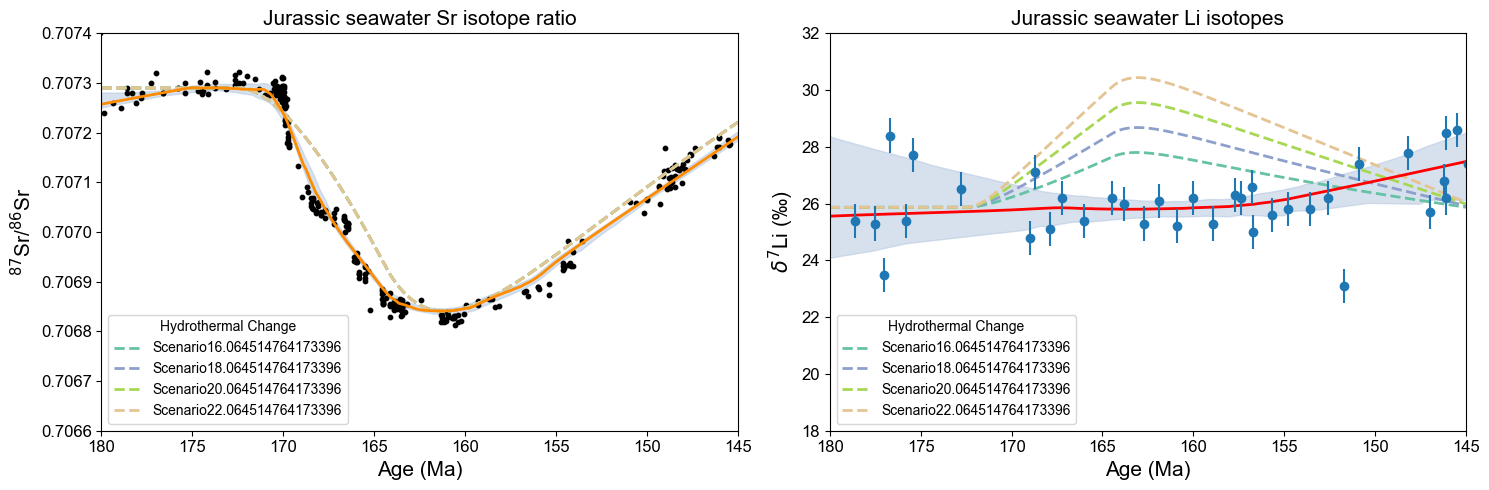

In [50]:
# SCENARIO 2.2 RIVERINE FLUX CHANGE IS SET, RIVERINE ISOTOPE RATIO INCREASES

#set turnning point time
start_age = 172
stop_age = 164

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

#----------------------------------------------------------------------------
#plot the data

fig, ax = plt.subplots(1, 2, figsize = (15, 5))


# Introduce changes
p = 0.68
Sr_Jriv[start:stop] = np.linspace(Sr_Jriv[0], Sr_Jriv[0]*p, (stop-start))
Sr_Jriv[stop:] = np.linspace(Sr_Jriv[0]*p, Sr_Jriv[0], (len(Sr_Jriv) - (stop)))
    
Li_fr[start:stop] = np.linspace(Li_fr[0], Li_fr[0]*p, (stop-start))
Li_fr[stop:] = np.linspace(Li_fr[0]*p, Li_fr[0], (len(Li_fr) - (stop)))

for i in range(4):
    Li_rr[start:stop] = np.linspace(Li_rr[0], Li_rr[0]+ 2*i, (stop - (start)))
    Li_rr[stop:] = np.linspace(Li_rr[0]+ 2*i, Li_rr[0], (len(Li_rr) - (stop)))

    #Run the model
    Li_Fsw_2_2 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
    Sr_Rsw_2_2 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)

    label = f"Scenario{Li_rr[0]+ 2*i}"
    
    ax[0].plot(age, Sr_Rsw_2_1, lw = 2, color = plt.cm.Set2(i*2), ls = '--', label = label)
    ax[1].plot(age, Li_Fsw_2_1, lw = 2, color = plt.cm.Set2(i*2), ls = '--', label = label)

    p -= 0.1

#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Strontium original data
ax[0].set_title("Jurassic seawater Sr isotope ratio", fontsize = 15)
ax[0].set_ylim(0.7066, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 2)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 2)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Li original data
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotopes", fontsize = 15)
ax[1].set_ylim(18, 32)
ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)

#---------------------------------------------------------
#add lengends
ax[0].legend(title="Hydrothermal Change", fontsize=10, loc="best")
ax[1].legend(title="Hydrothermal Change", fontsize=10, loc="best")

plt.tight_layout()
plt.show()

# save figure
# fig.savefig('Scenario_2_2.pdf', format='pdf')

In [53]:
# SCENARIO 3.1 HYDROTHERMAL AND RIVERINE CHANGE (MINIMUM)

"""
Riverine flux dominates isotopic changes:

Riverine flux decreases
Riverine isotope ratio remains table
Hydrotherml flux increase (minimum)

"""

#set turnning point time
start_age = 172
stop_age = 164

#convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]


#Introduce changes
q = 1.15

#MOR flux remains stable
Sr_Jh[start:stop] = np.linspace(Sr_Jh[0], Sr_Jh[0] *q, (stop-start))
Sr_Jh[stop:] = np.linspace(Sr_Jh[0] *q, Sr_Jh[0] , (len(Sr_Jriv) - (stop)))

Li_fh[start:stop] = np.linspace(Li_fh[0], Li_fh[0]*q, (stop-start))
Li_fh[stop:] = np.linspace(Li_fh[0]*q, Li_fh[0], (len(Li_fr) - (stop)))


#change the Sr and Li riverine flux
p = 0.8

Sr_Jriv[start:stop] = np.linspace(Sr_Jriv[0], Sr_Jriv[0]*p, (stop-start))
Sr_Jriv[stop:] = np.linspace(Sr_Jriv[0] * p, Sr_Jriv[0], (len(Sr_Jriv) - (stop)))

Li_fr[start:stop] = np.linspace(Li_fr[0], Li_fr[0]*p, (stop-start))
Li_fr[stop:] = np.linspace(Li_fr[0] * p, Li_fr[0], (len(Li_fr) - (stop)))

#Keep Li riverine isotope ratio stable
Li_rr[start:stop] = np.linspace(Li_rr[0],Li_rr[0] , (stop - (start)))
Li_rr[stop:] = np.linspace(Li_rr[0],Li_rr[0] , (len(Li_rr) - (stop)))

#Run the model
Li_Fsw_3_1 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
Sr_Rsw_3_1 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)


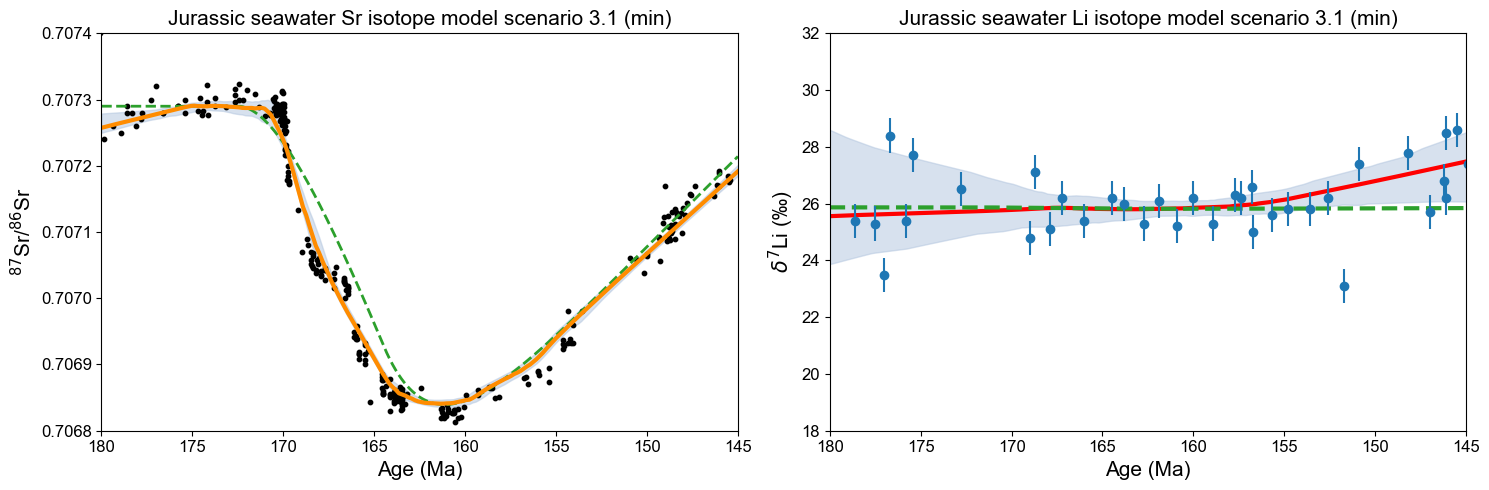

In [58]:
#-----------------------------------------------------------------------------------------------------------------
#plot scenario 3.1 minimum 
fig, ax = plt.subplots(1, 2, figsize = (15, 5))


#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Strontium data
ax[0].plot(age, Sr_Rsw_3_1, lw = 2, color = "C2", ls = '--')
ax[0].set_title("Jurassic seawater Sr isotope model scenario 3.1 (min)", fontsize = 15)
ax[0].set_ylim(0.7068, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 3)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 3)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#----------------------------------------------------------------------------

ax[1].plot(age, Li_Fsw_3_1, lw = 3, color = "C2", ls = '--')
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotope model scenario 3.1 (min)", fontsize = 15)
ax[1].set_ylim(18, 32)

ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)


plt.tight_layout()
plt.show()

# # save figure
# fig.savefig('Scenario_3_1.pdf', format='pdf')

In [61]:
# SCENARIO 3.2 HYDROTHERMAL AND RIVERINE CHANGE (MAXIMUM)

"""
MOR flux dominates isotopic changes:

Riverine flux remains stable
Riverine Li isotope ratio increases
MOR flux increases (maximum)

"""

#set turnning point time
start_age = 172
stop_age = 164

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

q = 1.41
#MOR flux increases
Sr_Jh[start:stop] = np.linspace(Sr_Jh[0], Sr_Jh[0] *q, (stop-start))
Sr_Jh[stop:] = np.linspace(Sr_Jh[0] *q, Sr_Jh[0] , (len(Sr_Jriv) - (stop)))

Li_fh[start:stop] = np.linspace(Li_fh[0], Li_fh[0]*q, (stop-start))
Li_fh[stop:] = np.linspace(Li_fh[0]*q, Li_fh[0], (len(Li_fr) - (stop)))

#change the Sr and Li riverine flux
p = 1

Sr_Jriv[start:stop] = np.linspace(Sr_Jriv[0], Sr_Jriv[0]*p, (stop-start))
Sr_Jriv[stop:] = np.linspace(Sr_Jriv[0] * p, Sr_Jriv[0], (len(Sr_Jriv) - (stop)))

Li_fr[start:stop] = np.linspace(Li_fr[0], Li_fr[0]*p, (stop-start))
Li_fr[stop:] = np.linspace(Li_fr[0] * p, Li_fr[0], (len(Li_fr) - (stop)))

#change Li riverine isotope ratio
Li_rr[start:stop] = np.linspace(Li_rr[0], 21, (stop - (start)))
Li_rr[stop:] = np.linspace(21, Li_rr[0] , (len(Li_rr) - (stop)))


#Run the model
Li_Fsw_3_2 = run_Li(Li_N, nt, dt, Li_rsw, Li_fr, Li_rr, Li_fh, Li_rh, Li_fsed, Li_dsed, Li_falt, Li_dalt)
Sr_Rsw_3_2 = run_Sim(nt, dt, age, Sr_Rsw, Sr_N, Sr_Jriv, Sr_Rriv, Sr_Jh, Sr_Rh, Sr_Jdia, Sr_Rdia)


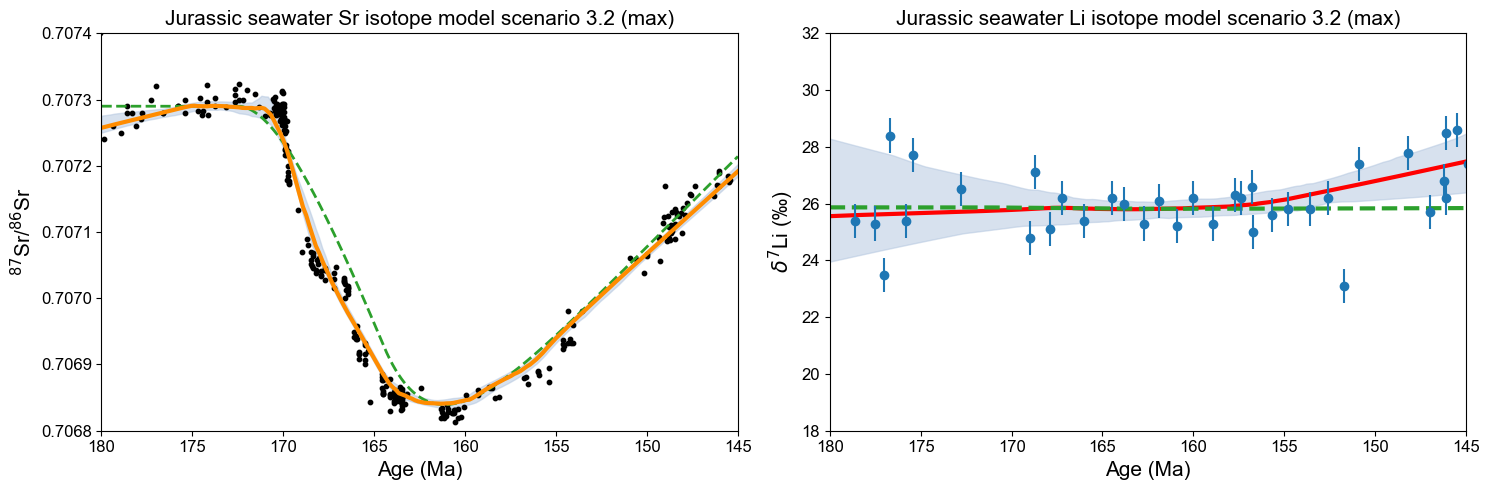

In [62]:
#-----------------------------------------------------------------------------------------------------------------
#plot scenario 3.2 maxmum
fig, ax = plt.subplots(1, 2, figsize = (15, 5))


#----------------------------------------------------------------------------
#Sr isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_Sr_age, real_Sr, eval_x, lowess_kw={"frac": 1/3}, N = 200
)

ax[0].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#plot Strontium data
ax[0].plot(age, Sr_Rsw_3_1, lw = 2, color = "C2", ls = '--')
ax[0].set_title("Jurassic seawater Sr isotope model scenario 3.2 (max)", fontsize = 15)
ax[0].set_ylim(0.7068, 0.7074)
ax[0].scatter(real_Sr_age, real_Sr, color = "black", s = 10);
ax[0].set_xlim(145, 180)
ax[0].invert_xaxis()
ax[0].plot(eval_x, smoothed, c = "darkorange", linewidth = 3)
ax[0].set_ylabel(r'$^{87}$Sr/$^{86}$Sr', fontsize = 15)
ax[0].set_xlabel('Age (Ma)', fontsize = 15)
ax[0].tick_params(axis='x', labelsize = 12)
ax[0].tick_params(axis='y', labelsize = 12)


#Lithium isotope LOWESS fitting
eval_x = np.linspace(145, 180, 200)
smoothed, bottom, top = lowess_with_confidence_bounds(
    real_age, real_d7Li + 5.5, eval_x, lowess_kw={"frac": 2/3}, N = 200
)

ax[1].plot(eval_x, smoothed, c = "red", linewidth = 3)
ax[1].fill_between(eval_x, bottom, top, alpha=0.5, color="lightsteelblue")


#----------------------------------------------------------------------------

ax[1].plot(age, Li_Fsw_3_1, lw = 3, color = "C2", ls = '--')
ax[1].set_xlim(145, 180)
ax[1].invert_xaxis()
ax[1].set_title("Jurassic seawater Li isotope model scenario 3.2 (max)", fontsize = 15)
ax[1].set_ylim(18, 32)

ax[1].errorbar(real_age, (real_d7Li + 5.5), yerr = 0.6, fmt = 'o', color = "C0")
ax[1].set_ylabel(r'$\delta^7$Li (‰)', fontsize = 15)
ax[1].set_xlabel('Age (Ma)', fontsize = 15)
ax[1].tick_params(axis='x', labelsize = 12)
ax[1].tick_params(axis='y', labelsize = 12)


plt.tight_layout()
plt.show()



# save figure
# fig.savefig('Scenario_3_2.pdf', format='pdf')